# Machine Learning Paradigms - Rental Bike Predictions



*This report demonstrates three approaches to a highly non-linear prediction task. Guassian process regression, tree regression and random forests are implemented and compared.*

## 1 | Introduction 
---
This report describes a solution to the **University of Bristol - Machine Learning Paradigms Kaggle competition**, which requires prediction of bicycle availability at rental stations across Valencia. The competition consists of three phases:

* **Phase 1**: Given a month of historical data from 75 [201:275] stations, predict 3 months of bicycle availability for each station, by 
    * (a) generating a learning model for each individual station, trained on it's own data
    * (b) generating a combined learning model which trains on all station data. <br><br>

* **Phase 2**: Predict bicycle availability by applying linear models trained on 200 other stations [1:200], where multiple models for each station have been provided. Determining the best blend of these models to produce optimim results is determined experimentally. <br><br>

* **Phase 3**: Attempt improved prediction performance by combining both the learning model from **Phase 1** and the linear models from **Phase 2**. <br><br>







## 2 | Methodology
----

### 2.1 | Data Exploration

The first step in the process of generating predicitive models is to properly understand the dataset. The dataset provided consists of various features, including information regarding the individual **station** and the **time** and **weather**, and task-related features to do with the time-history of number of bikes at each station. All features are listed in Table §§

#### Features ####

| Category | Features | Description |
| --- | -----------: | :--------- |
| Station | Station ID <br> Latitude <br> Longitude <br> Number of Docks | Non-correlated station ID number <br>  - <br> - <br> Max amount of bikes per station (varies between stations) |
| Time | Timestamp <br> Year <br> Month <br> Day <br> Hour <br> Weekday <br> Week-hour <br> Holiday | Seconds <br> - <br> - <br> - <br> - <br> Mon-Sun <br> 1:168 <br> 1 or 0 |
| Weather | Max Wind Speed <br> Mean Wind Speed <br> Wind Direction <br> Temperature <br> Relative Humidity <br> Air Pressure <br> Precipitation | $ms^{-1}$ <br> $ms^{-1}$ <br> $\text{\textdegree}$ <br> $C\text{\textdegree}$ <br> $\text{\%}$ <br> $mBar$ <br> $L/m^2$
| Task-Specific | Bikes 3h Ago | Number of bikes at a given station 3 hrs prior to the current timestamp |
| Profile | Full profile <br> Full profile 3 hours ago <br> Short Profile <br> Short Profile three hours ago | Average bike numbers for the current week-hour during all previous weeks <br> As above for 3 hrs prior <br> Average bike numbers for the current week-hour over the last four weeks <br> As above for 3 hrs prior |
|Target | Bikes | Number of bikes at the station i.e. the variable we are trying to predict

<br><br>

Understanding the impact of each feature on variance of bikes can be achieved statistically, but first we will simply observe them, to see if any obvious inferences can be made. 

We will look at the variation of number of bikes with respect to each feature, and also perform a single-component partial least squares (PLS) regression analysis. This yields a metric to help us better understand the correlation between each feature and the number of bikes. 

In [2]:
# LOAD MODULES & DATASET
%load_ext autoreload
%autoreload 2

from multiprocessing.sharedctypes import Value
import numpy as np
import random
import os
import pandas as pd
import plotly.express as px
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import SimpleImputer
import pickle

# User-defined
from utilities import data_saver
from fe_utilities import interpolation, weekday_handler, darkness, pca_app, station_proximity

# Set load/save path 
dw_directory = "./data" # Set data directory

stations = np.linspace(201, 275, 75)
dataset = pd.DataFrame()

for i in stations:
    filepath = os.path.join(dw_directory, 'Train', 'Train', 'station_' + str(int(i)) + '_deploy.csv')

    with open(filepath, 'r') as f:
        data_v = pd.read_csv(f)
         
        if len(dataset) == 0:
            dataset = data_v
        else:
            dataset = dataset.append(data_v)

bikes = pd.DataFrame(dataset['bikes'].copy())
dataset = dataset.drop(['bikes'],axis=1)

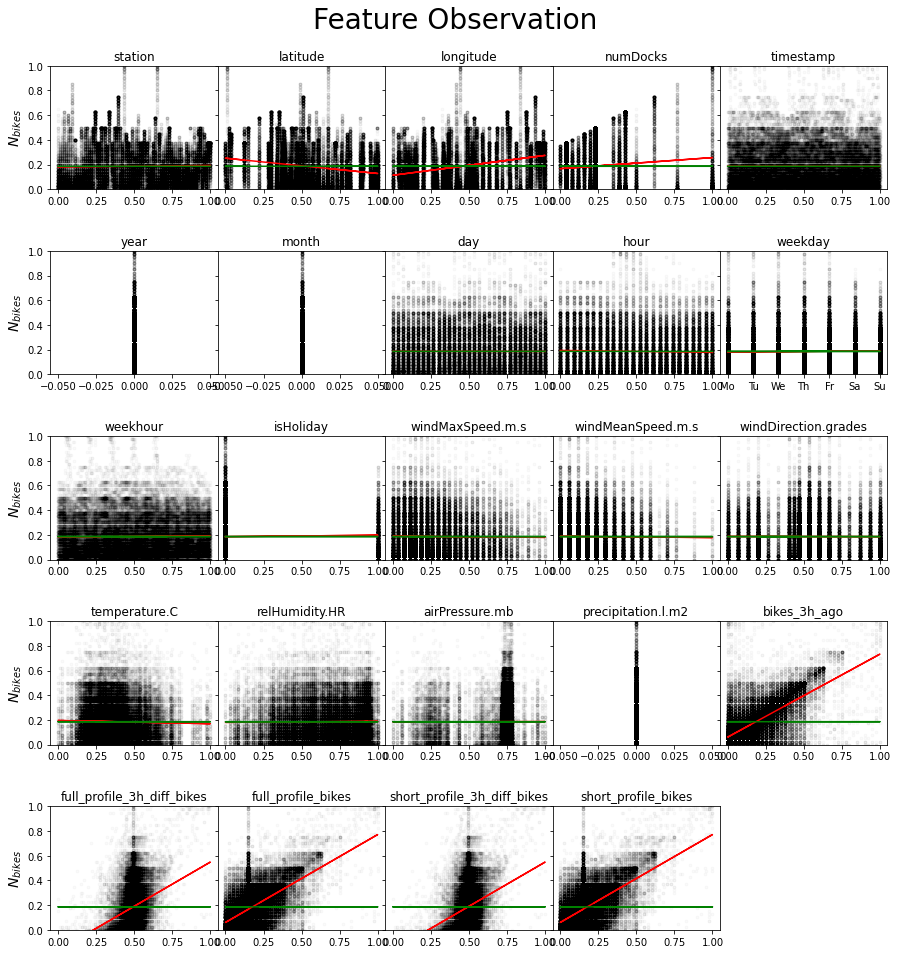

In [17]:
pls = PLSRegression(n_components=1,scale = False)
pls_data = {'Feature':[],'Score':[]}

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
columns = dataset.columns.values
scaler = MinMaxScaler()
n = len(columns)
n_sq = np.sqrt(n)
n_plt = int(np.ceil(n_sq))



fig, axs = plt.subplots(n_plt,n_plt, sharey=True,figsize=(15,15))
fig.suptitle('Feature Observation',fontsize = 28)

for i in range(0,n_plt**2):

    row = int(np.floor(i/n_plt))
    col = int(i%n_sq)

    if (n_plt*row + col) > n-1:
        axs[row,col].set_visible(False)
        
        continue

    x = dataset[columns[i]].values
    y = bikes['bikes']

    dotw = False
    weekDays = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    try:
        if 'day' in str(x[0]):
            x = [weekDays.index(n) for n in x]
            dotw = True
    except:
            pass
    
    x = [float(i) for i in x]
    x = np.reshape(np.array(x),(-1, 1))
    y = [float(i) for i in y]
    y = np.reshape(np.array(y),(-1, 1))

    scaler.fit(x)
    x = scaler.transform(x)
    imp_mean.fit(x)
    x = imp_mean.transform(x)
    
    scaler.fit(y)
    y = scaler.transform(y)
    imp_mean.fit(y)
    y = imp_mean.transform(y)

    # x = np.float32(x)
    # y = np.float32(y)
    y_mean = np.ones(len(y))*np.mean(y)

    try:
        pls.fit(x, y)
        corr_score = pls.score(x,y)
        # x = pls.transform(x)
        y_p = pls.predict(x)

        pls_data['Feature'].append(columns[i])
        pls_data['Score'].append(corr_score)

        axs[row,col].scatter(x,y,marker='.',c='k',alpha = 0.02) 
        axs[row,col].plot(x,y_p,c='r')
    except:
        axs[row,col].scatter(x,y,marker='.',c='k',alpha = 0.02) 

    axs[row,col].plot(x,y_mean,c='g') 
    axs[row,col].set_ylim([0,1])
    # axs[row,col].set_xlim([min(x),max(x)])
    axs[row,col].set_title(columns[i])

    if dotw == True:
        t_list = np.linspace(min(x),max(x),7)
        tick_list = [item for sublist in t_list for item in sublist]
        
        axs[row,col].set_xticks(tick_list, [d[0:2] for d in weekDays])

    if col == 0:
        axs[row,col].set_ylabel(r'$N_{bikes}$',fontsize =14)

plt.subplots_adjust(wspace=0,hspace = 0.5,top=0.925)
plt.savefig('data/USER/Figures/Feature_Observations.jpeg',dpi = 300,bbox_inches='tight')


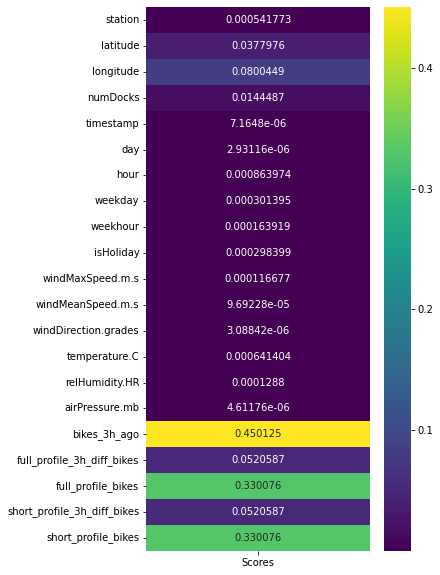

In [16]:
df = pd.DataFrame({"Scores": pls_data['Score']},
                  index=pls_data['Feature'])
plt.figure(figsize = (5,10))
ax = sns.heatmap(df, annot=True, fmt="g", cmap='viridis',yticklabels=pls_data['Feature'])

plt.savefig('data/USER/Figures/Feature_Correlation.jpeg',dpi = 300,bbox_inches='tight')

Figure §§ shows a plot of each feature (x) against number of bikes (y). A green line shows the mean number of bikes, and a red line indicates our "predictions" from the PLS analysis, which in this context is our line of best fit. The coefficient of determination ($R^2$) is calculated for each variable and is presented in Figure §§.

Looking at the feature plots, it is clear that **month**, **year** and **precipitation** will have zero effect on the results as they do not vary, and so they are ommited (however, if the models in Phase Two considered the month and year then this might not be the case). Here are some other guesses which are made from observing the data:

1. A small number of stations have a much higher capacity of docks than the rest
2. On holidays, and at weekends, these high capacity stations are never full
3. There is a concentration of bicycles in the South-East of Valencia
3. Both lower temperature and higher humidity indicate higher numbers of bikes
4. The number of bikes 3 hours ago is the feature with the most influence
5. For the profile features, the full and short profiles are identical

We can already begin to guess at some deeper meaning. For example, the high capacity stations could be in the city centre and therefore are not full on the weekends, as people take them to their home station. The weather observations (low temperature and high humidity) could be indicating that the stations are more full at night when people have returned their daily rentals.

For a final look at the data, we can plot latitude and longitude on a map of valencia, with markers representing the station capacity (grey) and the average number of bikes per station (red). This view provides a perspective of station business, as we can see very large capacity stations that are never full. It also confirms our suspicion of a higher number of bikes in the South East, perhaps this is more of a leisure destination and doesn't befall quite as much commuter traffic.

So, what does this mean for our modelling strategy? What the data has shown us is that our prediciton function is going to be complex, and probably not very smooth. While the profile variables give a relatively good line of best fit, there are other factors such as location, capacity and day of the week which create more of a classification problem. It is also hard to know what is a driving feature and what features are consequences of others. For example, there is a pattern which shows high bicycle numbers for a small pressure range; could this perhaps be because of similar pressures at the start of the work day or the end of the evening commute?


In [20]:
import folium

stations_lat = pd.unique(dataset['latitude'])
stations_long = pd.unique(dataset['longitude'])
stations_no = pd.DataFrame(pd.unique(dataset['station']), columns=['station'])
station_docks = dataset['numDocks'].values

stations = np.stack((stations_lat, stations_long), axis=1)
stations = pd.DataFrame(stations, columns = ['latitude', 'longitude'])

locations = stations[['latitude', 'longitude']]
locationlist = locations.values.tolist()

n_bikes = bikes['bikes'].values.reshape(-1,1)
imp_mean.fit(n_bikes)
n_bikes = imp_mean.transform(n_bikes)

stat_ns = dataset['station'].values

mean_bikes = []
numDocks = []

for i in range(0,len(stations_no.values)):
    
    stat_n = stations_no.values[i]
    t_f = stat_ns == stat_n

    index = [i for i, x in enumerate(t_f) if x]
    index = np.reshape(index,(-1,1))
    mean_bikes.append(sum(n_bikes[index])/len(n_bikes[index]))
    numDocks.append(station_docks[index])



f = folium.Figure(width=700, height=700)
map = folium.Map(location = [39.4502730411,-0.333362], tiles='OpenStreetMap' , zoom_start = 12)

for point in range(0, len(stations)):

    folium.Circle(
    locationlist[point],
    color='black',
    radius=float(10*numDocks[point][0][0]),
    fill=True,
    opacity=0.8,
    fill_opacity=0.2,
    # tooltip='Station {}: {}'.format(stations_no['station'][point],round(mean_bikes[point][0][0]))
    ).add_to(map)
    
    folium.Circle(
    locationlist[point],
    color='red',
    radius=10*mean_bikes[point][0][0],
    fill=True,
    opacity=0.1,
    fill_opacity=0.3,
    tooltip='Station {}| Docks: {} | Average Bikes {}'.format(stations_no['station'][point],numDocks[point][0][0],round(mean_bikes[point][0][0]))
    ).add_to(map)

    

f.add_child(map)
# f.savefig('data/USER/Figures/folium_valencia.jpeg',dpi = 300)
f

### 2.2 Feature Engineering

For the purposes of investigation, we define distinct datasets which will be used in our modelling to show the effects of including and excluding certain variable. Our control group will contain all of our data, with the exception of **"Weekday"**, which is converted to 7 one-hot encodings for days of the week. We then create two reduced versions of the control, removing our redundant variables (those which are observed not to vary or those which are duplications). For the case of training on individual stations, this includes station ID, latitide and longitude and number of docks, but these are kept in for training our collective model. A second sub-group consists only of the profile variables (and lat, long and number of docks for the cumulative model). Finally we experiement with a blend of profile data and some meta-data, creating one-hot encodings to indicate whether it is dark or the weekend (replacing our weekday encodings). Our sub-groups are defined in Table §§ and an 80:20 train-validation split is chosen for dividing data. Data is split at random.

| Group | Model       |   Features |
| :---: | ----------- | :--------- |
| $A$ <br> (control)    | Individual/ <br> Combined | 'station', 'latitude', 'longitude', 'numDocks', 'timestamp','year', 'month', 'day', 'hour', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'weekhour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades', 'temperature.C', 'relHumidity.HR', 'airPressure.mb', 'precipitation.l.m2', 'bikes_3h_ago', 'full_profile_3h_diff_bikes','full_profile_bikes', 'short_profile_3h_diff_bikes','short_profile_bikes'|
| $B_i$| Individual |'timestamp', 'day', 'hour', 'Monday','Tuesday','Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday', 'weekhour', 'isHoliday', 'windMaxSpeed.m.s', 'windMeanSpeed.m.s', 'windDirection.grades','temperature.C', 'relHumidity.HR','airPressure.mb', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes'|
| $B_c$| Combined| As above, plus 'station', 'latitude', 'longitude', 'numDocks'|
| $C_i$| Individual | 'bikes_3h_ago', 'full_profile_3h_diff_bikes','full_profile_bikes'|
| $C_c$| Combined| As above, plus 'latitude', 'longitude', 'numDocks'|
| $D_i$| Individual | 'weekhour', 'isDark', 'isWeekend', 'isHoliday', 'bikes_3h_ago', 'full_profile_3h_diff_bikes', 'full_profile_bikes'|
| $D_c$| Combined| As above, plus 'latitude', 'longitude', 'numDocks'|


### 2.3 Prediction Algorithms

We approach this problem with different methodologies to discern whether any approach stands out, namely:
* Bayesian Regression
* Tree Regression
* Tree Ensembles

The aim of this approach is to understand how these algorithms can handle this type of data, and so any conclusions drawn are constrained to similar contexts.

#### 2.3.1 Bayesian Regression
Our chosen approach to the regression problem is Gaussian process regression, as we can experiment with different covariance kernels and draw inferences about the results with respect to the smoothness of the predicted function. We will apply the Matern class of covariance kernels, with the covariance matrix is defined as:
<br><center>
$k_{x_i,x_j} = \dfrac{1}{\Gamma(\nu)2^{\nu-1}} \left(\dfrac{\sqrt{2\nu}}{l} d(x_i,x_j) \right)^\nu K_\nu \left(\dfrac{\sqrt{2\nu}}{l} d(x_i,x_j)  \right)$
</center>

where $ d(\cdot,\cdot)$ is euclidian distance, $K_\nu(\cdot)$ is a modified Bessel function, and $\Gamma(\cdot)$ is the gamma function. We modify the parameter $\nu$ to reflect our expectation of the smoothness of the data. As $\nu$ increases, so does our expectation that the data is smooth. For more detailed derivations and information on Matern covariance kernels, see §§insert ref - rasmussen 2006§§.

#### 2.3.2 Tree Regression
We use a tree-based regression method to predict the data, mostly due to the presence of categorical data in our input features. For each feature, the regression tree will iteratively split the data into clusters, and measure the squared residual error from assigning one output variable to each cluster. By finding the minimum squared residual error per split, and then recursively performing this step, a tree can be developed which segments the data (hopefully by our categorical features) then learns a function for each cluster. A good description of regression trees and their motivations is given in §§ inster ref: Gareth James et al An Introduction to Statistical Learning §§. We will modify min samples per leaf and maximum depth to understand whether the model is overfitting on the validation set.

#### 2.3.3 Tree Ensemble Methods
One problem with classic tree regression is accuracy - specifically, tree regressor commonly fit well to traiing data, but struggle to apply classifications to new samples; they are inflexible. One solution is this is to use a random forest ensemble method. This involves bootsrap aggregating, or bagging, whereby we randomly select subsets of variables in order to create a large variety of decision trees (hence, random forest!). Although each of these trees may produce poor predictions individually, by aggregating the results of each tree, it becomes possible to make a decision on the final output based on the most popular output term. Again, an in-depth description of this method is provide in §§gareth james et all: Intro to stats§§. Like in our tree method, we can modify minimum samples per leaf and maximum depth to investigate the effects of tree pruning.

### 2.4 Test Plan
The following presents a summary of the methods under test and associated parameter variation.

| Model |   Parameters | Parameter (Starting) Values |
| :---: | ----------- | :--------- | 
| Guassian Process Regression   | $\nu$     |  0.5; 1.5; 2.5 |
| Tree Regression |     Min. Samples Per Leaf <br> Maximum Depth| 1; 3; 5 <br> Max; Max_D/1.1 ; Max_D/1.3 Max_D/2|
| Random Forest Regression |     Min. Samples Per Leaf <br> Maximum Depth| 1; 3; 5 <br> Max; Max_D/1.1 ; Max_D/1.3 Max_D/2|

All models used are from the SciKit Learn family and are tuned in line with the steps outlined in the documentation. §insert sckikit ref§. The parameter values are referred to as **starting** values as we expect to stray from this set in the fine tuning of these models; these ranges indicate our initial search space.

### 2.5 Linear Models
Six types of linear models are provided for Phase 2, with individual weights for stations [1:200]. Assessment of these models is achieved by averaging the weights of each type of model and then performing inference on a test set. Initially the models are campared against eachother, and then performance of blended models is assessed. 

### 2.6 Model Combination
Finally we attempt to merge both linear models and our best performing model in order to beat our individual attempt. One method is to do some postprocessing (averaging or other) on both model predicitons and create an aggregated model. Another approach is investigated whereby we use the inputs of the linear models as training data inputs for our best model, to see whether this can help reduce overfitting on the test data.

## 4 | Results
----

### GPR

|Dataset | Parameter | Individual Model | Combined Model |
| -------|------------|-----------------|----------------|
| Group A| $\nu = 0.5$ |Training MAE = 3e-11  <br> Validation MAE = 6.475 | Failed |
| Group A| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 0.3  <br> Validation MAE = 1.82 | Failed |
| Group A| $\nu = 0.5$ <br> noise = 3.0|Training MAE = 0.16  <br> Validation MAE = 1.66 | Failed |
| Group A| $\nu = 0.5$ <br> noise = 4.0|Training MAE = 0.02  <br> Validation MAE = 1.60 <br> `Test MAE = 3.8`| Failed |
| Group A| $\nu = 0.5$ <br> noise = 8.0|Training MAE = 0.02  <br> Validation MAE = 1.60 | Failed |
| Group A| $\nu = 1.0$ <br> noise = 3.0|Training MAE = 0.92  <br> Validation MAE = 1.98 | Failed |
| Group A| $\nu = 1.5$ |Training MAE = 9.6e-12  <br> Validation MAE = 7.478 | Failed |
| Group A| $\nu = 1.5$ <br> noise = 2.0|Training MAE = 1.45  <br> Validation MAE = 2.42 | Failed |
| Group A| $\nu = 1.5$ <br> noise = 3.0|Training MAE = 0.95  <br> Validation MAE = 1.89 | Failed |
| Group A| $\nu = 1.5$ <br> noise = 4.0|Training MAE = 0.83  <br> Validation MAE = 1.83 <br> `Test MAE = 4.54`| Failed |
| Group A| $\nu = 1.5$ <br> noise = 8.0|Training MAE = 0.73  <br> Validation MAE = 1.76 | Failed |
| Group A| $\nu = 2.5$ <br> noise = 2.0|Training MAE = 1.69  <br> Validation MAE = 2.53 | Failed |
| Group A| $\nu = 2.5$ <br> noise = 4.0|Training MAE = 0.92  <br> Validation MAE = 1.86 <br> `Test MAE = 4.85`| Failed |
| Group A| $\nu = 2.5$ <br> noise = 8.0|Training MAE = 0.97  <br> Validation MAE = 1.86 | Failed |
|--------|--------|-------|
| Group B| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 0.38  <br> Validation MAE = 1.87 | Failed |
| Group B| $\nu = 0.5$ <br> noise = 4.0|Training MAE = 0.16  <br> Validation MAE = 1.69 <br> `Test MAE = 3.55` | Failed |
| Group B| $\nu = 1.0$ <br> noise = 2.0|Training MAE = 1.51  <br> Validation MAE = 2.52 | Failed |
| Group B| $\nu = 1.0$ <br> noise = 4.0|Training MAE = 0.68  <br> Validation MAE = 1.81 <br> `Test MAE = 3.89`| Failed |
|--------|--------|-------|
| Group C| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 2.29  <br> Validation MAE = 2.59 <br> `Test MAE = 2.63` | Failed |
| Group C| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 2.30  <br> Validation MAE = 2.51 | Failed |
| Group C| $\nu = 1.5$ <br> noise = 2.0|Training MAE = 2.48  <br> Validation MAE = 2.69 | Failed |
|--------|--------|-------|
| Group D| $\nu = 0.5$ <br> noise = 2.0|Training MAE = 0.87  <br> Validation MAE = 2.14 <br> `Test MAE = 2.96` | Failed |
| Group D| $\nu = 0.5$ <br> noise = 4.0|Training MAE = 0.87  <br> Validation MAE = 2.14 <br> `Test MAE = 2.97` | Failed |





### Regression Trees

|Dataset | Parameter | Individual Model | Combined Model |
| -------|------------|-----------------|----------------|
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.25 | Training MAE = 0.0  <br> Validation MAE = 2.97 |
| Group A| $n_{features} = 27$ <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.30 | Training MAE = 0.0  <br> Validation MAE = 3.02 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.29 | Training MAE = 0.0  <br> Validation MAE = 2.98 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.30 | Training MAE = 0.0  <br> Validation MAE = 3.08 |
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 3$ | Training MAE = 0.83  <br> Validation MAE = 2.24 <br> `Test MAE = 3.81` | Training MAE = 1.04  <br> Validation MAE = 2.88 <br> `Test MAE = 3.65`|
| Group A| $n_{features} = 27$ <br> $min_{samples} = 3$ |Training MAE = 0.85  <br> Validation MAE = 2.27 | Training MAE = 1.05  <br> Validation MAE = 2.84 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 3$ |Training MAE = 0.89  <br> Validation MAE = 2.28 | Training MAE = 1.07  <br> Validation MAE = 2.89 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 3$ |Training MAE = 0.96  <br> Validation MAE = 2.31 | Training MAE = 1.18  <br> Validation MAE = 2.88 |
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.25  <br> Validation MAE = 2.26 | Training MAE = 1.47  <br> Validation MAE = 2.75 |
| Group A| $n_{features} = 27$ <br> $min_{samples} = 5$ |Training MAE = 1.27  <br> Validation MAE = 2.26 <br> `Test MAE = 3.72`| Training MAE = 1.48  <br> Validation MAE = 2.74  <br> `Test MAE = 3.44`|
| Group A| $n_{features} = 23$ <br> $min_{samples} = 5$ |Training MAE = 1.29  <br> Validation MAE = 2.28 | Training MAE = 1.51  <br> Validation MAE = 2.81 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.39  <br> Validation MAE = 2.33 | Training MAE = 1.58  <br> Validation MAE = 2.80 |
|--------|---------|---------|--------|
| Group B| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.0  <br> Validation MAE = 2.25 | Training MAE = 0.0  <br> Validation MAE = 2.96 |
| Group B| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.32  <br> Validation MAE = 2.32 | Training MAE = 1.53  <br> Validation MAE = 2.79 |
|--------|---------|---------|--------|
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.09  <br> Validation MAE = 2.74 <br> `Test MAE = 2.83`| Training MAE = 2.07  <br> Validation MAE = 2.96 <br> `Test MAE = 2.99`|
|--------|---------|---------|--------|
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.00  <br> Validation MAE = 2.62 | Training MAE = 0.00  <br> Validation MAE = 3.39 |
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.67  <br> Validation MAE = 2.53 | Training MAE = 1.83  <br> Validation MAE = 3.04 |
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.08  <br> Validation MAE = 2.55 <br> `Test MAE = 3.09`| Training MAE = 2.12  <br> Validation MAE = 2.77 <br> `Test MAE = 2.91`|`YESY`
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 15$ |Training MAE = 2.26  <br> Validation MAE = 2.58 | Training MAE = 2.34  <br> Validation MAE = 2.85 |
| Group D| $n_{features} = 3$  <br> $min_{samples} = 1$ |Training MAE = 0.00  <br> Validation MAE = 2.68 | Training MAE = 0.00  <br> Validation MAE = 3.33 |
| Group D| $n_{features} = 3$  <br> $min_{samples} = 5$ |Training MAE = 1.84  <br> Validation MAE = 2.59 | Training MAE = 2.04  <br> Validation MAE = 2.96 |
| Group D| $n_{features} = 3$  <br> $min_{samples} = 10$ |Training MAE = 2.21  <br> Validation MAE = 2.57 <br> `Test MAE = 3.14` | Training MAE = 2.29  <br> Validation MAE = 2.75 <br> `Test MAE = 2.77`|
| Group D| $n_{features} = 3$  <br> $min_{samples} = 15$ |Training MAE = 2.38  <br> Validation MAE = 2.64 | Training MAE = 2.52  <br> Validation MAE = 2.92 |

### Random Forest

|Dataset | Parameter | Individual Model | Combined Model |
| -------|------------|-----------------|----------------|
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.70  <br> Validation MAE = 1.83 | Training MAE = 0.82  <br> Validation MAE = 2.26 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 1$ |Training MAE = 0.70  <br> Validation MAE = 1.81 <br> `Test MAE = 3.05` | Training MAE = 0.82  <br> Validation MAE = 2.26 <br> `Test MAE = 2.59`|
| Group A| $n_{features} = 15$ <br> $min_{samples} = 1$ |Training MAE = 0.69  <br> Validation MAE = 1.81 | Training MAE = 1.80  <br> Validation MAE = 2.24 |
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 3$ | Training MAE = 1.08  <br> Validation MAE = 1.90 | Training MAE = 1.22  <br> Validation MAE = 2.30 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 3$ |Training MAE = 1.40  <br> Validation MAE = 2.00 | Training MAE = 1.52  <br> Validation MAE = 2.33 |
| Group A| $n_{features} = 15$ <br> $min_{samples} = 3$ |Training MAE = 1.12  <br> Validation MAE = 1.91 <br> `Test MAE = 3.11` | Training MAE = 1.27  <br> Validation MAE = 2.20 <br> `Test MAE = 2.51`|
| Group A| $n_{features} = 30$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.37  <br> Validation MAE = 2.00 | Training MAE = 1.51  <br> Validation MAE = 2.33 |
| Group A| $n_{features} = 23$ <br> $min_{samples} = 5$ |Training MAE = 1.40  <br> Validation MAE = 2.00 | Training MAE = 1.52  <br> Validation MAE = 2.33
| Group A| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.49  <br> Validation MAE = 2.01 | Training MAE = 2.01  <br> Validation MAE = 2.34 |
|--------|--------|--------|-------|
| Group B| $n_{features} = 30$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.70  <br> Validation MAE = 1.83 | Training MAE = 0.82  <br> Validation MAE = 2.26 |
| Group B| $n_{features} = 15$ <br> $min_{samples} = 5$ |Training MAE = 1.39  <br> Validation MAE = 1.99 <br> `Test MAE = 2.94` | Training MAE = 1.54  <br> Validation MAE = 2.32 <br> `Test MAE = 2.41` |
|--------|---------|---------|--------|
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 1$ |Training MAE = 1.43  <br> Validation MAE = 2.60  | Training MAE = 1.40  <br> Validation MAE = 2.71 |
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 5$ |Training MAE = 2.16  <br> Validation MAE = 2.54  | Training MAE = 2.10  <br> Validation MAE = 2.69 |
| Group C| $n_{features} = 3$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.37  <br> Validation MAE = 2.54 <br> `Test MAE = 2.61` | Training MAE = 2.31  <br> Validation MAE = 2.70 <br> `Test MAE = 2.79`|
|--------|---------|---------|--------|
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 1$ |Training MAE = 2.37  <br> Validation MAE = 2.54 <br> `Test MAE = 2.61` | Training MAE = 2.31  <br> Validation MAE = 2.70 <br> `Test MAE = 2.92`|
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.76  <br> Validation MAE = 2.28  <br> `Test MAE = 2.75`| Training MAE = 1.76  <br> Validation MAE = 2.47 <br> `Test MAE = 2.46`|
| Group D| $n_{features} = 6$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.12 <br> Validation MAE = 2.40  <br> `Test MAE = 2.74`| Training MAE = 2.09  <br> Validation MAE = 2.52 <br> `Test MAE = 2.44`|
| Group D| $n_{features} = 3$ (max) <br> $min_{samples} = 1$ |Training MAE = 0.80 <br> Validation MAE = 2.13  <br> `Test MAE = 2.95`| Training MAE = 0.85  <br> Validation MAE = 2.32 <br> `Test MAE = 2.54`|
| Group D| $n_{features} = 3$ (max) <br> $min_{samples} = 5$ |Training MAE = 1.87 <br> Validation MAE = 2.31 | Training MAE = 1.94  <br> Validation MAE = 2.47 |
| Group D| $n_{features} = 3$ (max) <br> $min_{samples} = 10$ |Training MAE = 2.19 <br> Validation MAE = 2.42 <br> `Test MAE = 2.78`| Training MAE = 2.20  <br> Validation MAE = 2.53 <br> `Test MAE = 2.41`|

## 5 | Discussion
----

## 5.1 Model Behaviour

### 5.1.1 GPR

The GPR model training required some fine-tuning. During training it was found that the GPR was very sensitive to overfitting on per station models. This was mitigated by adding white noise to the covariance kernel. The result was a much more reasonable validation score, with a training score which showed reasonable fitting as opposed to the aggressive overfitting observed originally. As suspected, the best performance on the validation set is found when the Matern modification parameter $\nu = 0.5$, which implies that our data is highly non-linear.

The GPR method caused several optimisation warnings, and there was a delicate balance between the capability of the model and hardware limitations. The attempt to learn on the control dataset for the combined station data failed in evrey instance due to hardware limitations. By significantly reducing the dataset (Group C) it was hoped that a model trained on all station data could be successfully generated, but memory remained a limitation. 

### 5.1.2 Tree Regression
This model was subject to overfitting and required immediate parameter tuning. However, it is extremely computationally light in comparison to both other methods and implementation was much more straight forward than for the GPR method.

### 5.1.3 Random Forest
This was the most impressive model with respect to ease of implementation, speed of learning and ability to produce a relatively good set of results quickly. 

## 5.2 Model Results

### 5.2.1 GPR
The results for group A were quite poor, and could only be trained on individual training sets. This was likely a significant contributing factor to the overfitting of the model, as GPR's are typically very sensitive, particularly when applying low-matern covariance kernel parameters. Group B saw a significant improvement in mean absolute error for individually trained models, but this was still far behind both tree regression methods. Again, the model failed when atempted to learn on all stations. Group C, which used only three parameters for the dataset (the profile variables), saw significant improvement in GPR predicition with a mean average error of 2.6 achieved on the test set.

### 5.2.2 Tree Regression
The unconstrained initial attempts were observed to overfit on the training data for Group A and Group B. This was alleviated by adapting the minimum members in a leaf and the maximum number of features. Both parameters were suitable for reducing overfitting. 

Training on group B, it was observed that the change in MAE metrics was insignificant and so the entire results set it not populated. Setting the maximum number of features to one resulted in a very small amount of overfitting and similar results to the linear models, which was to be expected. 

For group C, of the two parameters which were modified (maximum features, minimum leaf members), the results tended to show more improvement when pruning with minimum samples per leaf, potentially due to the reduction in the number of features in the dataset. Even with fewer features, overfitting can be observed if minimum samples per leaf is not increased above 1. This group gave the lo

Group D saw the highest score for regression trees trained on all models. This may be due to the additional categories which were added providing good distinctions for the tree to split on. 

### 5.2.3 Random Forest
While similarly affected by the overfitting issues for regression trees, this model approach provided the strongest estimate prior to parameter tuning; scoring the highest in Group A and Group B, with the model trained on all stations providing a marginal boost over the individually trained stations.

Reducing the input space in Group C reduced the performance of the model, but it was still the strongest contender with an MAE of $2.61$, although the GPR predicted close to this value.

Testing on Group D illustrates that only a small subset of the actual data is requireed to predict bicycle numbers, as the random forest approach achieved almos identical error to the random forest trained on Group B data. This also highlights the statistical bagging approach as an effective method to eke out the most significant predictors for the output prediction, compared to both the tree regression and gaussian methods, which both struggled with overfitting. The test score is higher than the validation score for our final attempt; this is assumed to be because our validation set was quite large (20%: ~9000 points) and it is likely that the test set was smaller, which would explain fluctuations around the mean error.